<a href="https://colab.research.google.com/github/theouterlimitz/global-power-plant-database/blob/master/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_final = pd.read_pickle('analytical_data.pkl')
# ... continue with the rest of the EDA code ...

EDA Step 1: Analyze Water Stress by Fuel Type

The Question: How does baseline water stress differ across the most common types of power plants?

Loading the final analytical dataset...
Dataset loaded successfully.

Generating box plot of water stress scores by primary fuel type...


<ipython-input-2-aa2ab396555e>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_fuels,
<ipython-input-2-aa2ab396555e>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


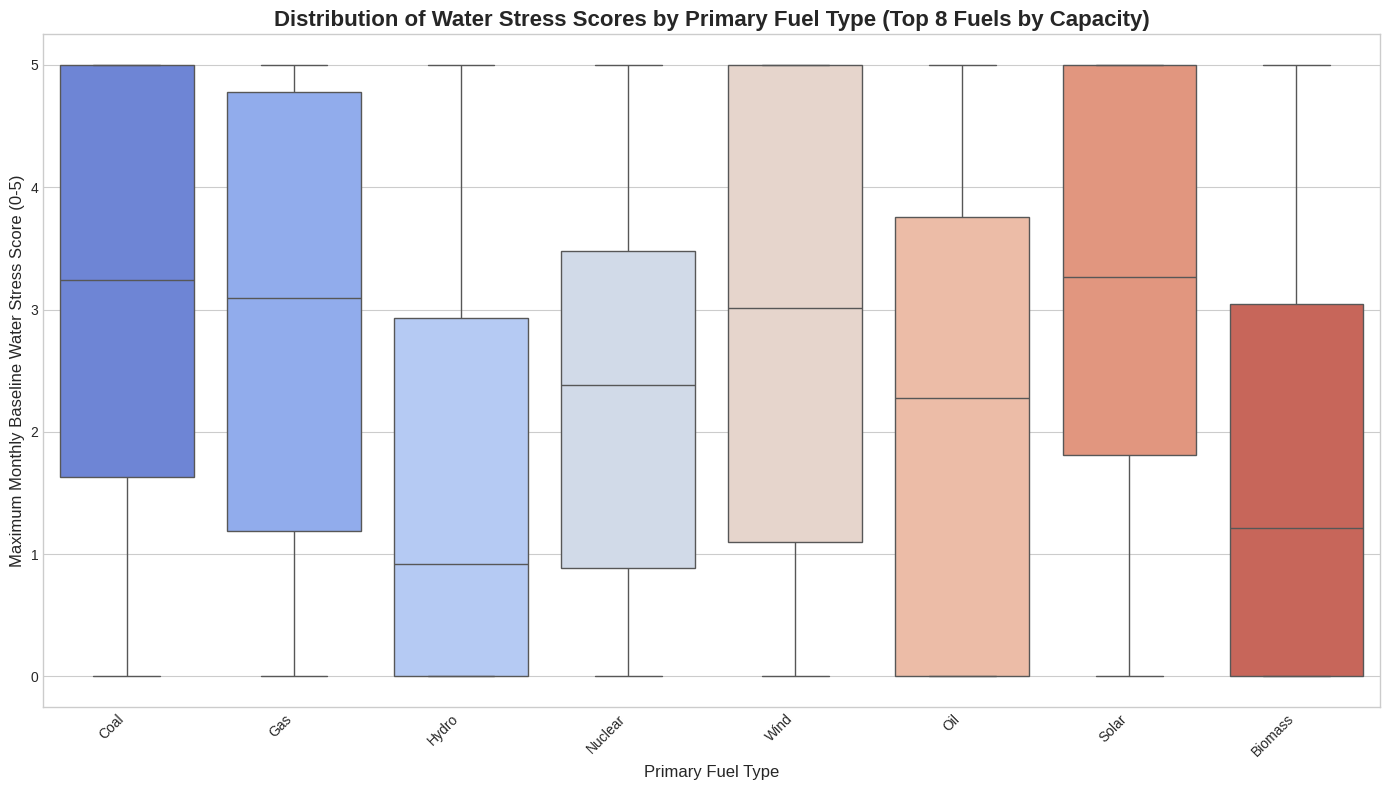

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Your Final Analytical Dataset ---
# We start here for all future analysis!
print("Loading the final analytical dataset...")
try:
    df_final = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found. Please ensure the file is in your Colab session.")
    # If the file is missing, you may need to re-run your Data Curation notebook to generate it.
    # Or upload it if you have it saved locally.


# --- Step 2: Prepare Data for this Analysis ---

# We already created the 'max_monthly_bws_score' and 'annual_bws_label'
# in our last script. Let's recreate them here to be safe.

# Identify all the monthly baseline water stress SCORE columns
bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
# For each power plant (row), find the maximum score it experiences across the 12 months
df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)

# For this plot, let's focus on the top 8 most common fuel types by capacity
top_fuels = df_final.groupby('primary_fuel')['capacity_mw'].sum().nlargest(8).index
df_top_fuels = df_final[df_final['primary_fuel'].isin(top_fuels)]


# --- Step 3: Visualize the Distribution ---
print("\nGenerating box plot of water stress scores by primary fuel type...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Create the box plot
sns.boxplot(data=df_top_fuels,
            x='primary_fuel',
            y='max_monthly_bws_score',
            ax=ax,
            order=top_fuels, # Ensure a consistent order
            palette='coolwarm')

ax.set_title('Distribution of Water Stress Scores by Primary Fuel Type (Top 8 Fuels by Capacity)', fontsize=16, fontweight='bold')
ax.set_xlabel('Primary Fuel Type', fontsize=12)
ax.set_ylabel('Maximum Monthly Baseline Water Stress Score (0-5)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

The Insight/Observation:

High-Risk Profiles: Coal, Gas, Solar, and Oil plants show the highest median water stress scores, indicating they are frequently sited in water-stressed regions.

Low-Risk Profile: Wind power stands out with a very low median water stress score, highlighting a key advantage in terms of water-related risk.

Mixed-Risk Profile: Hydropower has a lower median risk but a very wide distribution, reflecting its dependence on rivers in various climates.

Using 34595 plants with valid location and water stress data.
Sampling 5000 plants for mapping.

Generating world map of power plant water stress...


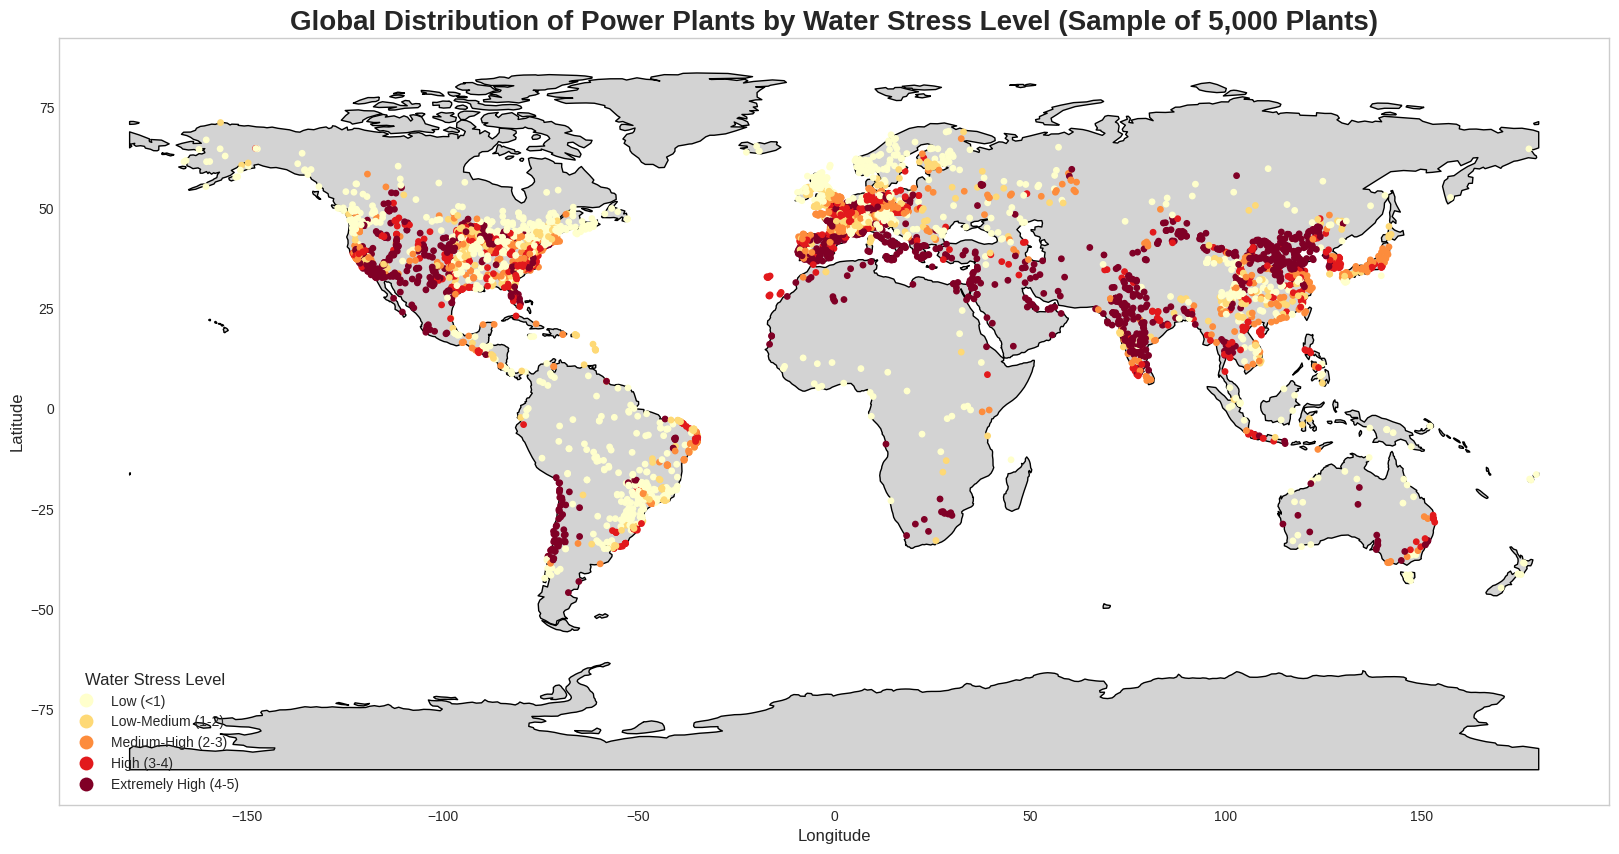

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# --- Assume df_final is already loaded from our previous step ---
# If you are in a new session, uncomment the line below to load your clean data
# df_final = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# --- Step 1: Prepare the data for mapping ---
# ===================================================================

# If 'max_monthly_bws_score' doesn't exist, create it.
if 'max_monthly_bws_score' not in df_final.columns:
    print("Calculating 'max_monthly_bws_score'...")
    bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
    df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)

# Create a clear categorical label for the water stress score.
score_bins = [-1, 1, 2, 3, 4, 5.1]
score_labels = [
    'Low (<1)',
    'Low-Medium (1-2)',
    'Medium-High (2-3)',
    'High (3-4)',
    'Extremely High (4-5)'
]
df_final['annual_bws_label'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)

# Drop any plants that couldn't be matched or have no stress score for cleaner plotting.
df_for_map = df_final.dropna(subset=['annual_bws_label', 'geometry']).copy()
print(f"Using {len(df_for_map)} plants with valid location and water stress data.")

# Take a random sample to keep the map readable and fast to render.
df_sample = df_for_map.sample(n=min(5000, len(df_for_map)), random_state=42)
print(f"Sampling {len(df_sample)} plants for mapping.")


# ===================================================================
# --- Step 2: Create the World Map ---
# ===================================================================
print("\nGenerating world map of power plant water stress...")

# ** THE FINAL FIX IS HERE **
# We will load the world map directly from a reliable GeoJSON URL.
# This bypasses all local library and server download issues.
try:
    url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
    world = gpd.read_file(url)

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot the base world map
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Plot the power plant data points on top
    df_sample.plot(ax=ax,
                   column='annual_bws_label',
                   categorical=True,
                   legend=True,
                   markersize=15,
                   cmap='YlOrRd',
                   legend_kwds={
                       'title': "Water Stress Level",
                       'loc': 'lower left',
                       'title_fontsize': '12',
                       'fontsize': '10'
                   })

    ax.set_title('Global Distribution of Power Plants by Water Stress Level (Sample of 5,000 Plants)', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(False)

    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

"What is the fuel mix (in terms of total capacity) within each water stress category?"

Preparing data to analyze fuel mix by risk category...

Fuel Mix (in MW) by Water Stress Category:
primary_fuel             Biomass         Coal            Gas        Hydro  \
annual_bws_label                                                            
Low (<1)              19827.3884  348626.8780  278648.170600  671212.9620   
Low-Medium (1-2)       3791.2992  141730.9600  124296.563460  103435.8319   
Medium-High (2-3)      3517.4530  344001.9700  230474.986200   91826.2170   
High (3-4)             2868.2990  336237.0140  266259.449000   86444.8079   
Extremely High (4-5)   3854.6900  772942.9776  577959.138889   99552.9180   

primary_fuel            Nuclear            Oil          Solar        Wind  
annual_bws_label                                                           
Low (<1)              107453.00   38648.015090   19603.357325  50966.0834  
Low-Medium (1-2)       52601.00   23094.685000   14879.118105  27512.0239  
Medium-High (2-3)      92501.90   43299.235850   23085.83

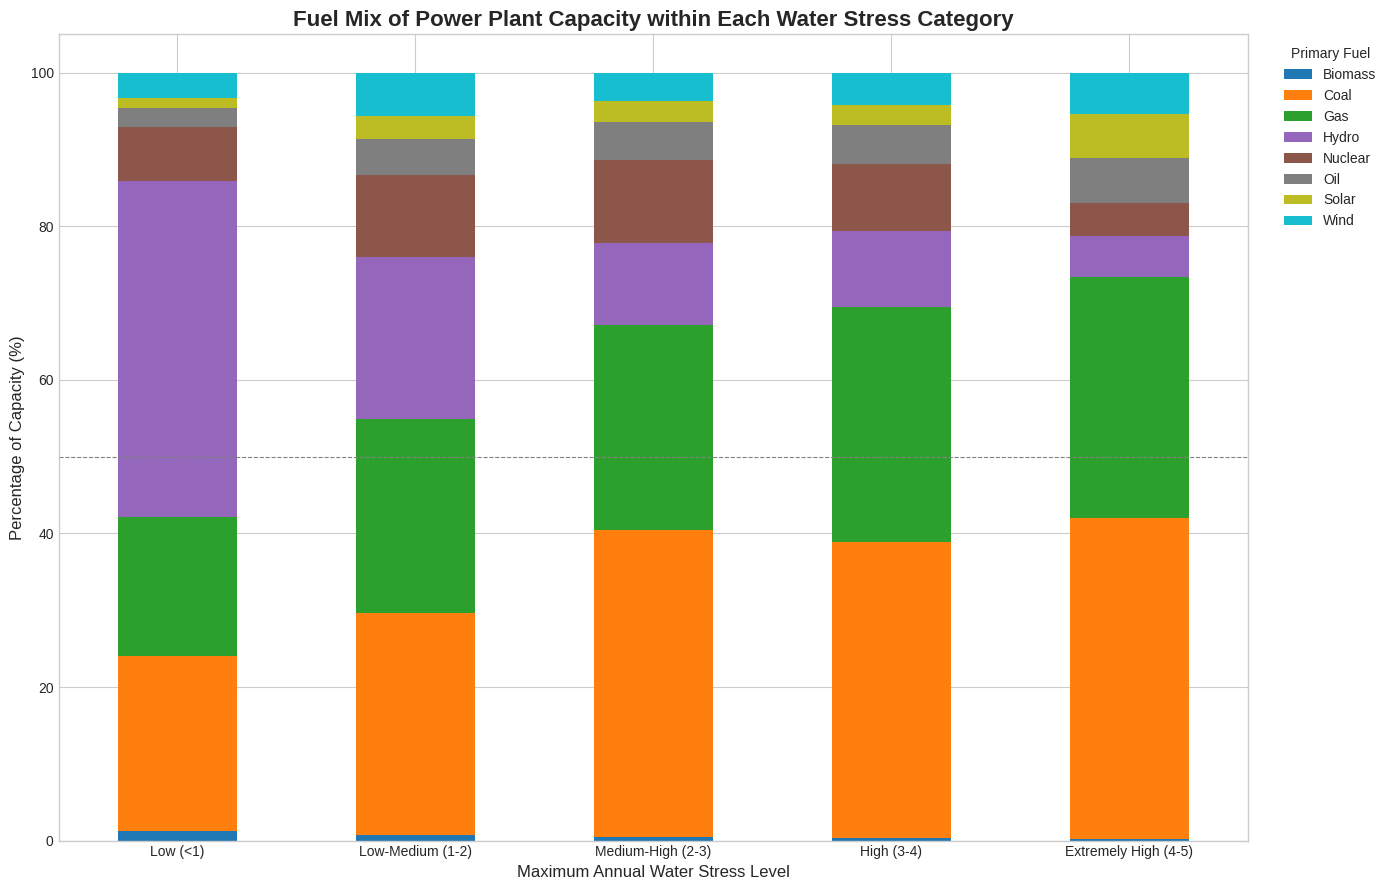

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_final is already loaded from our previous step ---
# If you are in a new session, uncomment the line below
# df_final = pd.read_pickle('analytical_data.pkl')

# ===================================================================
# --- Step 1: Prepare the data for this analysis ---
# ===================================================================
print("Preparing data to analyze fuel mix by risk category...")

# We'll use the same 'annual_bws_label' we created for the map
# And the 'top_fuels' list from the box plot analysis
top_fuels = df_final.groupby('primary_fuel')['capacity_mw'].sum().nlargest(8).index
df_top_fuels = df_final[df_final['primary_fuel'].isin(top_fuels)]

# Create a pivot table to get capacity for each fuel type within each risk category
fuel_risk_pivot = pd.crosstab(
    index=df_top_fuels['annual_bws_label'],
    columns=df_top_fuels['primary_fuel'],
    values=df_top_fuels['capacity_mw'],
    aggfunc='sum'
).fillna(0)

# Calculate percentages for a 100% stacked bar chart
fuel_risk_pivot_perc = fuel_risk_pivot.div(fuel_risk_pivot.sum(axis=1), axis=0) * 100

print("\nFuel Mix (in MW) by Water Stress Category:")
print(fuel_risk_pivot)


# ===================================================================
# --- Step 2: Visualize the Fuel Mix ---
# ===================================================================
print("\nGenerating stacked bar chart...")

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 9))
fuel_risk_pivot_perc.plot(kind='bar', stacked=True, ax=ax, cmap='tab10')

# Formatting the plot
ax.set_title('Fuel Mix of Power Plant Capacity within Each Water Stress Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Maximum Annual Water Stress Level', fontsize=12)
ax.set_ylabel('Percentage of Capacity (%)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Primary Fuel', bbox_to_anchor=(1.02, 1), loc='upper left')

# Add a horizontal line at 50% for reference
ax.axhline(50, color='grey', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

"How does the distribution of power plant capacity across water stress levels change from the baseline to a future scenario (e.g., 2050 business-as-usual)?"

Loading the final analytical dataset...
Dataset loaded successfully.

Preparing data for future scenario analysis...

DEBUG: Available columns containing 'bau50':
['bau50_ba_x_r', 'bau50_ba_x_l', 'bau50_ww_x_r', 'bau50_ww_x_l', 'bau50_ws_x_r', 'bau50_ws_x_s', 'bau50_ws_x_c', 'bau50_ws_x_l', 'bau50_wd_x_r', 'bau50_wd_x_s', 'bau50_wd_x_c', 'bau50_wd_x_l', 'bau50_iv_x_r', 'bau50_iv_x_s', 'bau50_iv_x_c', 'bau50_iv_x_l', 'bau50_sv_x_r', 'bau50_sv_x_s', 'bau50_sv_x_c', 'bau50_sv_x_l']

Comparison Data:
     Water Stress Level      Baseline  2050 (Business as Usual)
0              Low (<1)  1.546989e+06              1.708221e+06
1      Low-Medium (1-2)  4.943731e+05              7.966888e+05
2     Medium-High (2-3)  8.668321e+05              8.902848e+05
3            High (3-4)  8.788627e+05              7.891240e+05
4  Extremely High (4-5)  1.856011e+06              1.458750e+06

Generating comparison plot...


<ipython-input-5-e6d46d3e1e54>:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_capacity = df_final.groupby('baseline_ws_label')['capacity_mw'].sum()
<ipython-input-5-e6d46d3e1e54>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  future_capacity_bau50 = df_final.groupby('future_ws_label_bau50')['capacity_mw'].sum()


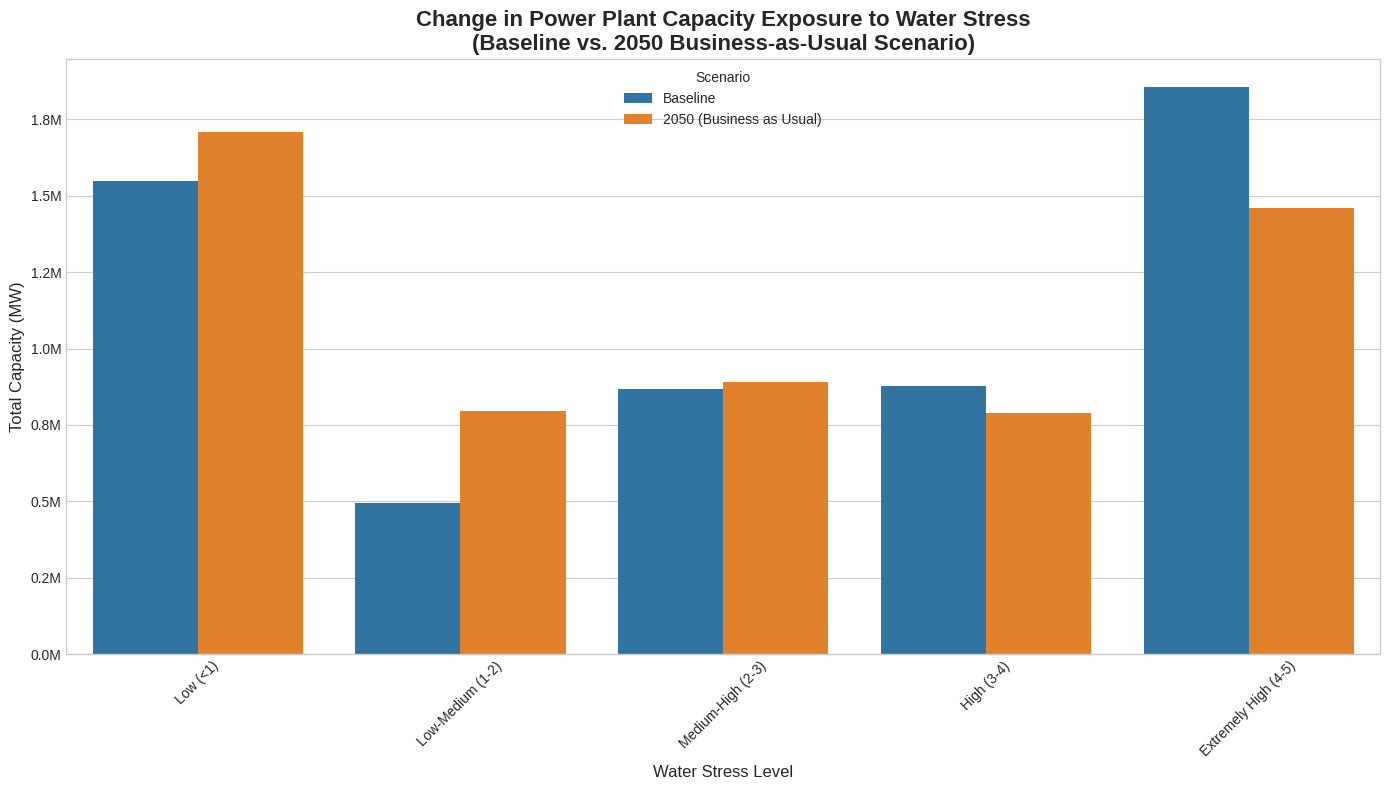

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Load Your Final Analytical Dataset ---
print("Loading the final analytical dataset...")
try:
    df_final = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found.")
    df_final = pd.DataFrame()


# --- Step 2: Prepare Data for Comparison ---
if not df_final.empty:
    print("\nPreparing data for future scenario analysis...")

    # --- Debugging Step: Let's look at the actual column names ---
    print("\nDEBUG: Available columns containing 'bau50':")
    bau50_cols = [col for col in df_final.columns if 'bau50' in col]
    print(bau50_cols)
    # -------------------------------------------------------------

    # Define score bins and labels
    score_bins = [-1, 1, 2, 3, 4, 5.1]
    score_labels = [
        'Low (<1)',
        'Low-Medium (1-2)',
        'Medium-High (2-3)',
        'High (3-4)',
        'Extremely High (4-5)'
    ]

    # Create Baseline Label (if it doesn't exist)
    if 'max_monthly_bws_score' not in df_final.columns:
        bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
        df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)
    df_final['baseline_ws_label'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)

    # Create Future Scenario Label using the CORRECT column name
    future_score_column = 'bau50_ws_x_s'
    df_final['future_ws_label_bau50'] = pd.cut(df_final[future_score_column], bins=score_bins, labels=score_labels)

    # --- Calculate Capacity Totals for Each Scenario ---
    baseline_capacity = df_final.groupby('baseline_ws_label')['capacity_mw'].sum()
    future_capacity_bau50 = df_final.groupby('future_ws_label_bau50')['capacity_mw'].sum()

    # Combine into a single DataFrame for plotting
    comparison_df = pd.DataFrame({
        'Baseline': baseline_capacity,
        '2050 (Business as Usual)': future_capacity_bau50
    }).reset_index()
    comparison_df.rename(columns={'index': 'Water Stress Level'}, inplace=True)

    # Melt the DataFrame for easier plotting with seaborn
    comparison_df_melted = comparison_df.melt(id_vars='Water Stress Level', var_name='Scenario', value_name='Total Capacity (MW)')

    print("\nComparison Data:")
    print(comparison_df)

    # --- Step 3: Visualize the Comparison ---
    print("\nGenerating comparison plot...")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    sns.barplot(data=comparison_df_melted, x='Water Stress Level', y='Total Capacity (MW)', hue='Scenario', ax=ax)

    ax.set_title('Change in Power Plant Capacity Exposure to Water Stress\n(Baseline vs. 2050 Business-as-Usual Scenario)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Water Stress Level', fontsize=12)
    ax.set_ylabel('Total Capacity (MW)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    ax.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f}M')

    plt.tight_layout()
    plt.show()
else:
    print("Could not load data. Skipping analysis.")

"How does the 2050 water stress risk profile for power plants change across the Optimistic, Business-as-Usual, and Pessimistic scenarios?"

Loading the final analytical dataset...
Dataset loaded successfully.

Preparing data for full scenario comparison...

Full Comparison Data (first 5 rows):
     Water Stress Level  Total Capacity (MW)  Scenario
0              Low (<1)         1.546989e+06  Baseline
1      Low-Medium (1-2)         4.943731e+05  Baseline
2     Medium-High (2-3)         8.668321e+05  Baseline
3            High (3-4)         8.788627e+05  Baseline
4  Extremely High (4-5)         1.856011e+06  Baseline

Generating full comparison plot...


<ipython-input-6-e4ace5614c49>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-6-e4ace5614c49>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-6-e4ace5614c49>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = 

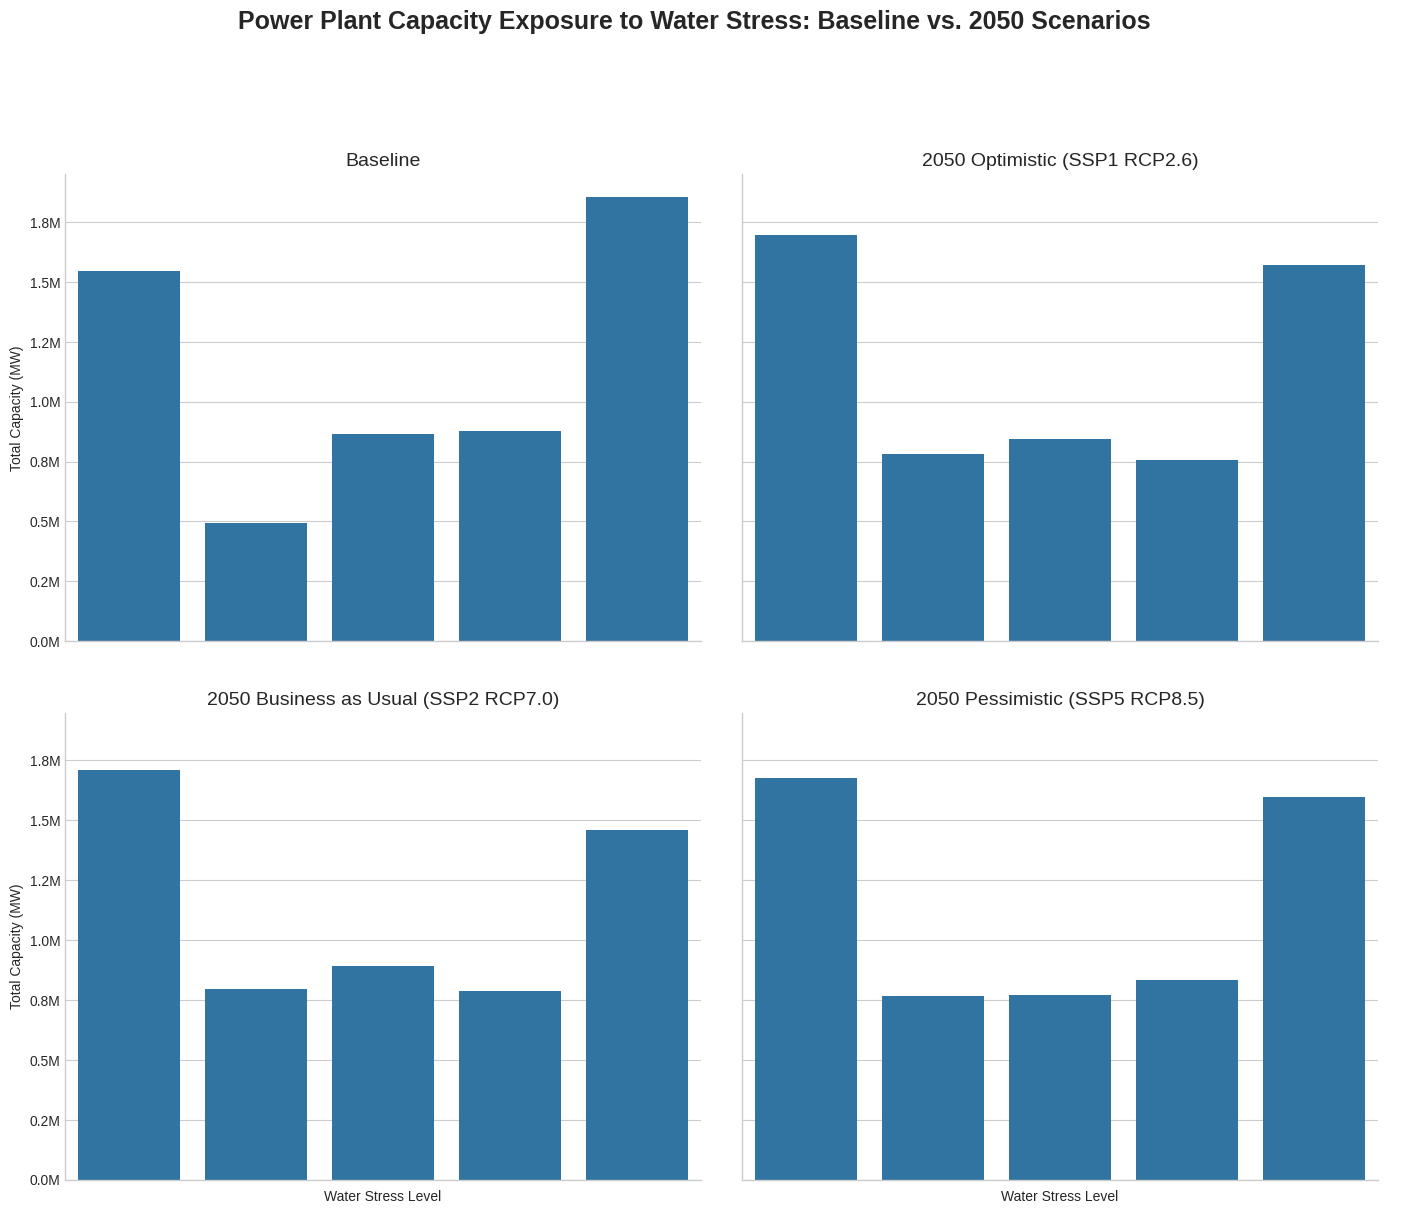

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Load Your Final Analytical Dataset ---
print("Loading the final analytical dataset...")
try:
    df_final = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found.")
    df_final = pd.DataFrame()

# --- Step 2: Prepare Data for Full Scenario Comparison ---
if not df_final.empty:
    print("\nPreparing data for full scenario comparison...")

    # Define score bins and labels, consistent with previous plots
    score_bins = [-1, 1, 2, 3, 4, 5.1]
    score_labels = [
        'Low (<1)',
        'Low-Medium (1-2)',
        'Medium-High (2-3)',
        'High (3-4)',
        'Extremely High (4-5)'
    ]

    # Create labels for Baseline and all three 2050 Scenarios
    # Baseline
    if 'max_monthly_bws_score' not in df_final.columns:
        bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
        df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)
    df_final['Baseline'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)

    # Future Scenarios
    df_final['2050 Optimistic (SSP1 RCP2.6)'] = pd.cut(df_final['opt50_ws_x_s'], bins=score_bins, labels=score_labels)
    df_final['2050 Business as Usual (SSP2 RCP7.0)'] = pd.cut(df_final['bau50_ws_x_s'], bins=score_bins, labels=score_labels)
    df_final['2050 Pessimistic (SSP5 RCP8.5)'] = pd.cut(df_final['pes50_ws_x_s'], bins=score_bins, labels=score_labels)

    # --- Calculate Capacity Totals for Each Scenario ---
    scenarios = ['Baseline', '2050 Optimistic (SSP1 RCP2.6)', '2050 Business as Usual (SSP2 RCP7.0)', '2050 Pessimistic (SSP5 RCP8.5)']
    all_scenarios_data = []
    for scenario in scenarios:
        capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
        capacity_by_risk.rename(columns={scenario: 'Water Stress Level'}, inplace=True)
        capacity_by_risk['Scenario'] = scenario
        all_scenarios_data.append(capacity_by_risk)

    # Combine into a single DataFrame for plotting
    comparison_df_all = pd.concat(all_scenarios_data)
    comparison_df_all.rename(columns={'capacity_mw': 'Total Capacity (MW)'}, inplace=True)

    print("\nFull Comparison Data (first 5 rows):")
    print(comparison_df_all.head())

    # --- Step 3: Visualize the Full Comparison ---
    print("\nGenerating full comparison plot...")

    plt.style.use('seaborn-v0_8-whitegrid')
    # Using catplot for a faceted view, which is great for comparisons
    g = sns.catplot(
        data=comparison_df_all,
        x='Water Stress Level',
        y='Total Capacity (MW)',
        col='Scenario',
        kind='bar',
        col_wrap=2, # Wrap into 2 columns
        height=6,
        aspect=1.2,
        sharey=True # Keep the Y-axis consistent
    )

    g.fig.suptitle('Power Plant Capacity Exposure to Water Stress: Baseline vs. 2050 Scenarios', y=1.03, fontsize=18, fontweight='bold')
    g.set_axis_labels("Water Stress Level", "Total Capacity (MW)")
    g.set_xticklabels(rotation=45, ha='right')
    g.set_titles("{col_name}", size=14)

    # Format y-axis to be more readable
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f}M')

    plt.tight_layout(pad=3.0)
    plt.show()
else:
    print("Could not load data. Skipping analysis.")

In [ ]:
import pandas as pd
import numpy as np

# Load your final analytical dataset
df_final = pd.read_pickle('analytical_data.pkl')

# --- Re-create the necessary columns ---
print("Re-creating summary and label columns...")
score_bins = [-1, 1, 2, 3, 4, 5.1]
score_labels = ['Low (<1)', 'Low-Medium (1-2)', 'Medium-High (2-3)', 'High (3-4)', 'Extremely High (4-5)']
bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
df_final[bws_score_cols] = df_final[bws_score_cols].replace(-9999, np.nan)
df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)
df_final['annual_bws_label'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)
# (We don't need the future labels for this specific CSV)

# --- Select columns for the dashboard, NOW INCLUDING the numeric score ---
columns_for_dashboard = [
    'name', 'country_long', 'capacity_mw', 'latitude', 'longitude',
    'primary_fuel', 'commissioning_year', 'estimated_generation_gwh_2017',
    'annual_bws_label', 'max_monthly_bws_score' # <-- ADDED THIS COLUMN
]
df_for_dashboard = df_final[columns_for_dashboard].copy() # Use .copy() to avoid warnings

# --- Export the updated CSV ---
dashboard_csv_filename = 'data_for_dashboard_v2.csv'
df_for_dashboard.to_csv(dashboard_csv_filename, index=False)
print(f"\nSuccessfully exported the updated dashboard data to '{dashboard_csv_filename}'")

Re-creating summary and label columns...

Successfully exported the updated dashboard data to 'data_for_dashboard_v2.csv'


In [ ]:
import pandas as pd
import numpy as np

# Load your final analytical dataset
df_final = pd.read_pickle('analytical_data.pkl')

# --- Create all the necessary label columns ---
print("Creating all baseline and future scenario labels...")
score_bins = [-1, 1, 2, 3, 4, 5.1]
score_labels = ['Low (<1)', 'Low-Medium (1-2)', 'Medium-High (2-3)', 'High (3-4)', 'Extremely High (4-5)']
bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
df_final[bws_score_cols] = df_final[bws_score_cols].replace(-9999, np.nan)
df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)

df_final['Baseline'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)
df_final['2050 Optimistic'] = pd.cut(df_final['opt50_ws_x_s'], bins=score_bins, labels=score_labels)
df_final['2050 Business as Usual'] = pd.cut(df_final['bau50_ws_x_s'], bins=score_bins, labels=score_labels)
df_final['2050 Pessimistic'] = pd.cut(df_final['pes50_ws_x_s'], bins=score_bins, labels=score_labels)

# --- Restructure the data into a 'long' format ---
scenarios = ['Baseline', '2050 Optimistic', '2050 Business as Usual', '2050 Pessimistic']
all_scenarios_data = []
for scenario in scenarios:
    capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
    capacity_by_risk.rename(columns={scenario: 'Water Stress Level', 'capacity_mw': 'Total Capacity (MW)'}, inplace=True)
    capacity_by_risk['Scenario'] = scenario
    all_scenarios_data.append(capacity_by_risk)

comparison_df_long = pd.concat(all_scenarios_data)

# --- Export the new CSV for this chart ---
scenario_csv_filename = 'data_for_scenario_chart.csv'
comparison_df_long.to_csv(scenario_csv_filename, index=False)
print(f"\nSuccessfully exported the scenario data to '{scenario_csv_filename}'")

Creating all baseline and future scenario labels...

Successfully exported the scenario data to 'data_for_scenario_chart.csv'


<ipython-input-8-1db2bf6b8409>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-8-1db2bf6b8409>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-8-1db2bf6b8409>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = 

Final EDA Step: Comparing All Future Scenarios

Loading the final analytical dataset from 'analytical_data.pkl'...
Dataset loaded successfully.

Preparing data for full scenario comparison...

Generating full comparison plot...


<ipython-input-1-b131ed29d957>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-1-b131ed29d957>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
<ipython-input-1-b131ed29d957>:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  capacity_by_risk = 

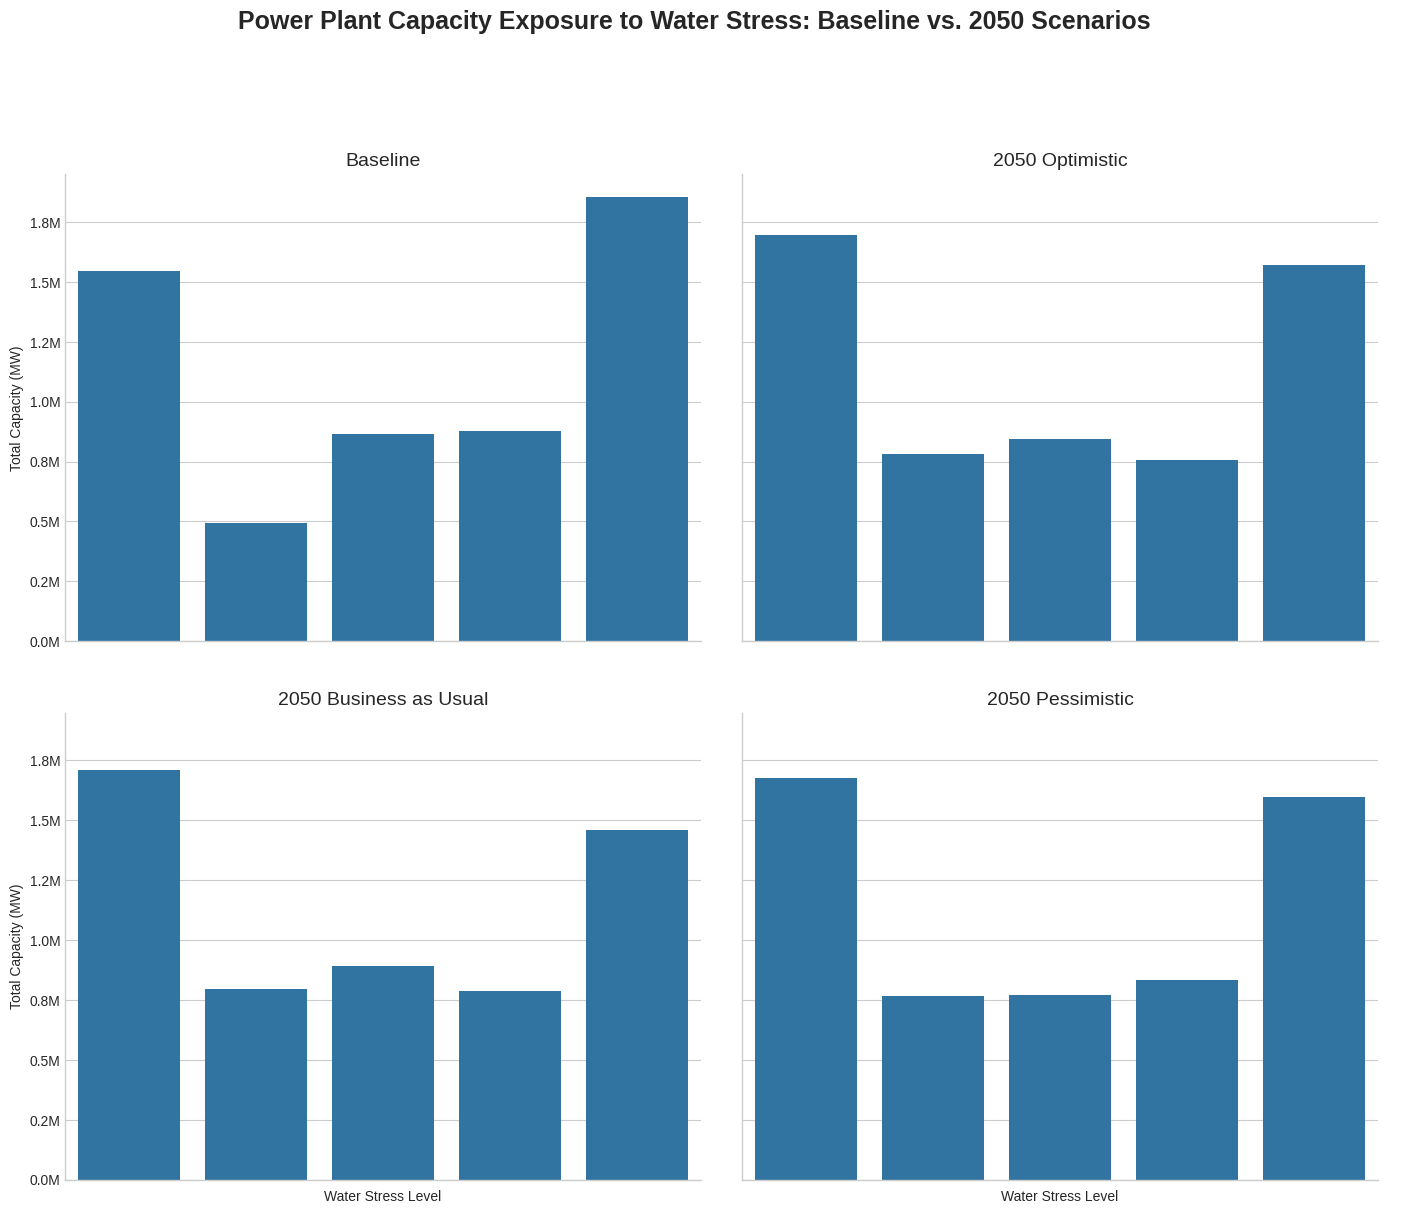

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Load Your Final Analytical Dataset ---
print("Loading the final analytical dataset from 'analytical_data.pkl'...")
try:
    df_final = pd.read_pickle('analytical_data.pkl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'analytical_data.pkl' not found. Please ensure it is uploaded to this Colab session.")
    df_final = pd.DataFrame()

# --- Step 2: Prepare Data for Full Scenario Comparison ---
if not df_final.empty:
    print("\nPreparing data for full scenario comparison...")

    # Define score bins and labels, consistent with our previous plots
    score_bins = [-1, 1, 2, 3, 4, 5.1]
    score_labels = [
        'Low (<1)',
        'Low-Medium (1-2)',
        'Medium-High (2-3)',
        'High (3-4)',
        'Extremely High (4-5)'
    ]

    # --- Create labels for Baseline and all three 2050 Scenarios ---

    # Baseline
    if 'max_monthly_bws_score' not in df_final.columns:
        bws_score_cols = [f'bws_{month:02d}_score' for month in range(1, 13)]
        df_final[bws_score_cols] = df_final[bws_score_cols].replace(-9999, np.nan)
        df_final['max_monthly_bws_score'] = df_final[bws_score_cols].max(axis=1)
    df_final['Baseline'] = pd.cut(df_final['max_monthly_bws_score'], bins=score_bins, labels=score_labels)

    # Future Scenarios using the correct column names
    df_final['2050 Optimistic'] = pd.cut(df_final['opt50_ws_x_s'], bins=score_bins, labels=score_labels)
    df_final['2050 Business as Usual'] = pd.cut(df_final['bau50_ws_x_s'], bins=score_bins, labels=score_labels)
    df_final['2050 Pessimistic'] = pd.cut(df_final['pes50_ws_x_s'], bins=score_bins, labels=score_labels)

    # --- Restructure the data into a 'long' format for easy plotting ---
    scenarios = ['Baseline', '2050 Optimistic', '2050 Business as Usual', '2050 Pessimistic']
    all_scenarios_data = []

    for scenario in scenarios:
        # Group by the scenario's label column and sum the capacity
        capacity_by_risk = df_final.groupby(scenario)['capacity_mw'].sum().reset_index()
        # Rename columns for consistency
        capacity_by_risk.rename(columns={scenario: 'Water Stress Level', 'capacity_mw': 'Total Capacity (MW)'}, inplace=True)
        # Add a column to identify which scenario this data belongs to
        capacity_by_risk['Scenario'] = scenario
        all_scenarios_data.append(capacity_by_risk)

    # Combine the data for all scenarios into one DataFrame
    comparison_df_all = pd.concat(all_scenarios_data)

    # --- Step 3: Visualize the Full Comparison ---
    print("\nGenerating full comparison plot...")

    plt.style.use('seaborn-v0_8-whitegrid')
    # Using catplot for a faceted view is great for comparing categories across scenarios
    g = sns.catplot(
        data=comparison_df_all,
        x='Water Stress Level',
        y='Total Capacity (MW)',
        col='Scenario',
        kind='bar',
        col_wrap=2, # Arrange the 4 plots in a 2x2 grid
        height=6,
        aspect=1.2,
        sharey=True, # Keep the Y-axis the same for all plots for easy comparison
        order=score_labels # Ensure the x-axis is ordered logically
    )

    g.fig.suptitle('Power Plant Capacity Exposure to Water Stress: Baseline vs. 2050 Scenarios', y=1.03, fontsize=18, fontweight='bold')
    g.set_axis_labels("Water Stress Level", "Total Capacity (MW)")
    g.set_xticklabels(rotation=45, ha='right')
    g.set_titles("{col_name}", size=14)

    # Format the y-axis labels to be more readable (e.g., 1.5M instead of 1500000)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(lambda x, pos: f'{x/1e6:.1f}M')

    plt.tight_layout(pad=3.0)
    plt.show()

else:
    print("Could not load data. Skipping analysis.")